# 🧠 DeepFake Detection - scSE Model Baseline (단계별 학습 버전)
---
이 노트북은 scSE 기반 딥페이크 탐지 모델을 단계적으로 학습하고 성능을 평가하기 위한 베이스라인입니다.
각 단계별로 설명이 포함되어 있어 성능 실험 및 구조 튜닝 시 활용할 수 있습니다.

In [ ]:
# import sys
# !{sys.executable} -m pip install matplotlib

In [ ]:
# import sys
# !{sys.executable} -m pip install seaborn

In [1]:
# ================================================
# 라이브러리 Import 및 기본 설정
# ================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# ================================================
# 기본 학습 환경 설정
# ================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Using device: {device}')

model_dir = './'
os.makedirs(model_dir, exist_ok=True)

✅ Using device: cpu


## [2단계] 데이터셋 준비 및 전처리
이미지를 224x224로 리사이즈하고 정규화하여 학습 준비를 합니다.

##### 1. 기본적인 전처리 코드

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(2),  # 회전 폭 조금 줄이기
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 1.2))], p=0.2),  
    transforms.RandomApply([transforms.RandomAdjustSharpness(1.3)], p=0.3),
    transforms.RandomGrayscale(p=0.05),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # 살짝 랜덤 크롭으로 일반화 강화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 통계 사용
                         std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                     # 검증은 증강 없이 그대로
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 데이터셋 로드 ---
train_dir = '../../train'
val_dir = '../../val'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

# --- 데이터로더 ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')
print(f'Classes: {train_dataset.classes}')

Train samples: 12000, Val samples: 3000
Classes: ['Fake', 'Real']


## [3단계] scSE 블록 및 모델 정의
scSE는 채널 및 공간 주의력을 결합하여 특징 표현을 강화합니다.

In [3]:
# ======================================
# scSE Block (채널 + 공간 주의)
# ======================================
class scSEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        reduced_ch = max(channels // reduction, 8)

        # 채널 주의 (Channel Squeeze & Excitation)
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, reduced_ch, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_ch, channels, kernel_size=1),
            nn.Sigmoid()
        )

        # 공간 주의 (Spatial Squeeze & Excitation)
        self.sSE = nn.Sequential(
            nn.Conv2d(channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * (1 + 0.5 * (self.cSE(x) + self.sSE(x)))

# ======================================
# ScSEModel (ResNet18 백본 기반)
# ======================================
class ScSEModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # ImageNet 가중치 미사용 (대회 규정 고려)
        base = models.resnet18(weights=None)

        # ResNet 기본 레이어 + scSE 블록 삽입
        self.layer0 = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = nn.Sequential(*base.layer1, scSEBlock(64))
        self.layer2 = nn.Sequential(*base.layer2, scSEBlock(128))
        self.layer3 = nn.Sequential(*base.layer3, scSEBlock(256))
        self.layer4 = nn.Sequential(*base.layer4, scSEBlock(512))

        # 분류기 헤드
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

        # 초기화 수행 (PreTrainedModel.post_init() 대체)
        self._init_weights()
        # BN 안정화 (작은 momentum)
        self._set_bn_momentum(0.01)

    # ---------------------------
    # 가중치 초기화 (HuggingFace 수준)
    # ---------------------------
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    # ---------------------------
    # BatchNorm 모멘텀 안정화
    # ---------------------------
    def _set_bn_momentum(self, momentum=0.05):
        for m in self.modules():
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
                m.momentum = momentum

    # ---------------------------
    # Forward
    # ---------------------------
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# ======================================
# 모델 생성 예시
# ======================================
model = ScSEModel(num_classes=2).to(device)
print(model)

ScSEModel(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (

## [4단계] 학습 및 검증 루프
모델을 학습하고 Validation 데이터에서 Accuracy 및 F1 Score를 계산합니다.

In [4]:
# ===============================
# 손실함수, 옵티마이저, 스케줄러 설정
# ===============================
criterion = nn.CrossEntropyLoss(label_smoothing=0.03)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 10
best_f1 = 0.0
train_losses, val_losses, f1_scores = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f'[Epoch {epoch+1}/{num_epochs}] Train'):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping (폭주 방지)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    # 스케줄러 업데이트
    scheduler.step()

    # 평균 학습 손실
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    # =================================
    # Validation
    # =================================
    model.eval()
    preds, trues, val_loss = [], [], 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    f1_scores.append(f1)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}')

    if f1 > best_f1:
        best_f1 = f1
        save_path = './best_model.pth'
        torch.save(model.state_dict(), save_path)
        print(f'✅ Best model saved (F1={best_f1:.4f})')

[Epoch 1/10] Train: 100%|██████████| 375/375 [17:44<00:00,  2.84s/it]


Epoch 1/10 | Train Loss=0.5685, Val Loss=1.2744, Acc=0.5750, F1=0.5088
✅ Best model saved (F1=0.5088)


[Epoch 2/10] Train: 100%|██████████| 375/375 [16:24<00:00,  2.62s/it]


Epoch 2/10 | Train Loss=0.4008, Val Loss=0.6860, Acc=0.7017, F1=0.6921
✅ Best model saved (F1=0.6921)


[Epoch 3/10] Train: 100%|██████████| 375/375 [16:19<00:00,  2.61s/it]


Epoch 3/10 | Train Loss=0.3361, Val Loss=0.4879, Acc=0.7827, F1=0.7805
✅ Best model saved (F1=0.7805)


[Epoch 4/10] Train: 100%|██████████| 375/375 [16:28<00:00,  2.64s/it]


Epoch 4/10 | Train Loss=0.2761, Val Loss=0.4103, Acc=0.8223, F1=0.8223
✅ Best model saved (F1=0.8223)


[Epoch 5/10] Train: 100%|██████████| 375/375 [16:09<00:00,  2.58s/it]


Epoch 5/10 | Train Loss=0.2404, Val Loss=0.5046, Acc=0.7890, F1=0.7816


[Epoch 6/10] Train: 100%|██████████| 375/375 [22:15<00:00,  3.56s/it]


Epoch 6/10 | Train Loss=0.2142, Val Loss=0.3683, Acc=0.8627, F1=0.8616
✅ Best model saved (F1=0.8616)


[Epoch 7/10] Train: 100%|██████████| 375/375 [22:05<00:00,  3.53s/it]


Epoch 7/10 | Train Loss=0.1956, Val Loss=0.3087, Acc=0.8913, F1=0.8913
✅ Best model saved (F1=0.8913)


[Epoch 8/10] Train: 100%|██████████| 375/375 [16:10<00:00,  2.59s/it]


Epoch 8/10 | Train Loss=0.1751, Val Loss=0.3001, Acc=0.9033, F1=0.9033
✅ Best model saved (F1=0.9033)


[Epoch 9/10] Train: 100%|██████████| 375/375 [16:02<00:00,  2.57s/it]


Epoch 9/10 | Train Loss=0.1644, Val Loss=0.3169, Acc=0.8953, F1=0.8951


[Epoch 10/10] Train: 100%|██████████| 375/375 [15:41<00:00,  2.51s/it]


Epoch 10/10 | Train Loss=0.1549, Val Loss=0.2930, Acc=0.9027, F1=0.9027


## [5단계] 성능 분석 및 시각화
Loss, F1 Score 변화와 Confusion Matrix를 시각화하여 학습 결과를 분석합니다.

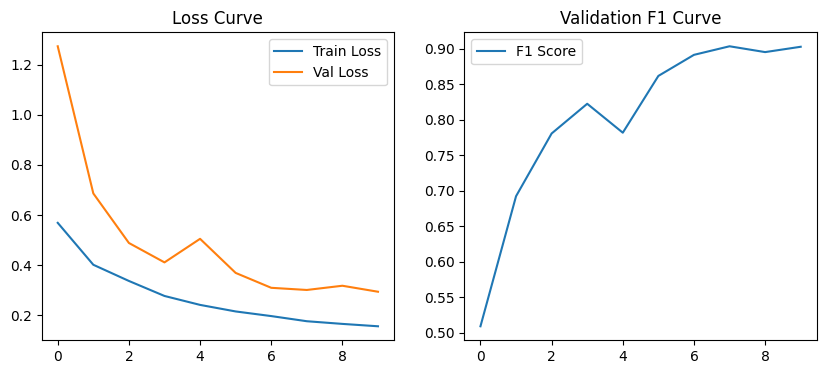

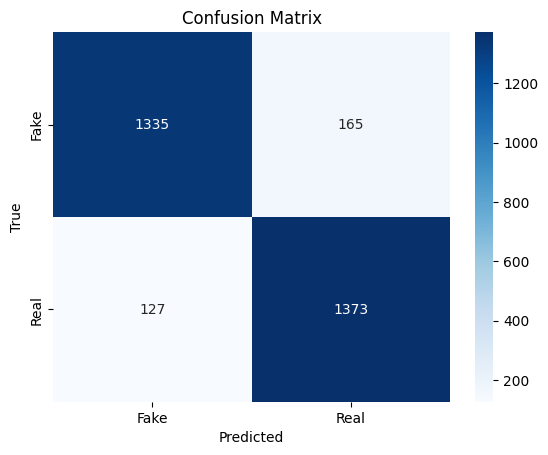


Classification Report:

              precision    recall  f1-score   support

        Fake     0.9131    0.8900    0.9014      1500
        Real     0.8927    0.9153    0.9039      1500

    accuracy                         0.9027      3000
   macro avg     0.9029    0.9027    0.9027      3000
weighted avg     0.9029    0.9027    0.9027      3000



In [5]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(f1_scores, label='F1 Score')
plt.legend(); plt.title('Validation F1 Curve')
plt.show()

# Confusion Matrix 시각화
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ✅ Classification Report (표 형태)
from sklearn.metrics import classification_report

print("\nClassification Report:\n")
print(classification_report(trues, preds,
                            target_names=train_dataset.classes, 
                            digits=4))
